# Background

Kolya Larson (Group 1)

**Planet:** HD189733 b

**Steps:**

1. *Measure the planet's mass + uncertainty based on RV data (Cassie).*

2. **Measure the planet's radius + uncertainty based on the transit data.**

3. *Calculate planet's density + uncertainty after measuring its mass and radius (Cassie).*

4. Create comparison plots for mass, radius, and density from NEA data.

5. *Compare with the Chen & Kipping (2016) M-R relationship.*

-----------------------------------------
Data sourced from: http://var2.astro.cz/ETD/index.php (author: JOSEP GAITAN)

Bayesian sampling: http://www.inference.org.uk/mackay/itprnn/ps/457.466.pdf

I also found this to be useful: https://www.geol.lsu.edu/jlorenzo/geophysics/uncertainties/Uncertaintiespart2.html , https://faraday.physics.utoronto.ca/PVB/Harrison/ErrorAnalysis/Propagation.htmlfor error propogation.

Used data from https://exoplanetarchive.ipac.caltech.edu/ for the overlay plot comparing HD189733 b to other exoplanets.

Chen & Kipping's paper was found here: https://arxiv.org/pdf/1603.08614.pdf

# Finding Radius

The data available on var2 provided measurements of the heliocentric Julian date, magnitude of the star's brightness, and error in the magnitude. 

The radius of the host star HD 189733 was most accurately given on NEA, from Rosenthal et al. 2021, as

$$ 	0.78271930158600000 ± 0.01396094224705000 R_⦿ $$

The following equation allows me to solve for the radius of the planet
$$
f=(\frac{R_p}{R_*})^2
$$

when the planet is entirely transiting the star. The planet was found to have a radius of 

$$ 1.138 ± 0.027 R_J $$

by Josep Gaitan, which is who also gathered the data, so we should expect to find something similar.

**Imports:**

In [1]:
import pandas as pd                     # Required for reading the .csv from NEA

import astropy                          # Useful package for working with astronomy specific units and constants

from astropy import units as u

from astropy import constants as c

import numpy as np                      # Useful mathematical functions

import matplotlib.pyplot as plt         # Required for plotting data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving tdata.dat to tdata.dat


In [3]:
transit = pd.read_csv('tdata.dat',delimiter="\s+",comment='#')            # Import data

transit.head()                         # Check that the data imported correctly..

,HJD,Mag,Err
0,2.459435e+06,-0.00892,0.00156
1,2.459435e+06,-0.01234,0.00157
2,2.459435e+06,-0.01123,0.00155
3,2.459435e+06,-0.01129,0.00155
4,2.459435e+06,-0.01041,0.00155


Now I have to convert the magnitude to normalized flux. The distance to the system is 19.7109 ± 0.0188 pc as given on NEA.

(I am not going to pay attention to the uncertainties yet, as that will be done in the next section.)

Since I have the data values for the apparent magnitude, I am able to convert to absolute magnitude using
$$
m-M=5log(d/10)
$$
where m is the apparent magnitude, M is the absolute magnitude, and d is the distance to the object in parsecs.

In [4]:
# Find absolute magnitude for apparent magnitudes given in data.
 
abmag=[]                             # Empty list we will put calculated absolute magnitudes in
d=19.7109                            # Distance to system in pc

for i in range(len(transit.Mag)):
    value=transit['Mag'][i]-5*np.log10(d/10)      # Solve for M in the equation.
    abmag.append(value)                        # Append value onto list

transit['ABMag']=abmag                        # Append 

transit.head()                                # Check it worked

,HJD,Mag,Err,ABMag
0,2.459435e+06,-0.00892,0.00156,-1.482452
1,2.459435e+06,-0.01234,0.00157,-1.485872
2,2.459435e+06,-0.01123,0.00155,-1.484762
3,2.459435e+06,-0.01129,0.00155,-1.484822
4,2.459435e+06,-0.01041,0.00155,-1.483942


Next we can convert these absolute magnitudes into luminosities using 
$$
M=4.83-2.5log(\frac{L}{L_0})
$$
Where L_0 is the luminosity of the sun.

In [5]:
# Find luminosities in terms of L_0.

lums=[]                             # Empty list we will put calculated luminosities in

for i in range(len(transit.Mag)):
    value=10**((4.83-transit['ABMag'][i])/2.5) # Solve for L in the equation.
    lums.append(value)                        # Append value onto list

transit['Lum']=lums                           # Append 

transit.head()                                # Check it worked

,HJD,Mag,Err,ABMag,Lum
0,2.459435e+06,-0.00892,0.00156,-1.482452,334.950715
1,2.459435e+06,-0.01234,0.00157,-1.485872,336.007452
2,2.459435e+06,-0.01123,0.00155,-1.484762,335.664111
3,2.459435e+06,-0.01129,0.00155,-1.484822,335.682661
4,2.459435e+06,-0.01041,0.00155,-1.483942,335.410697


Now that we know both the luminosities and the distance to the system we can find the flux values knowing
$$
F=\frac{L}{4πd^2}
$$

In [6]:
# Find fluxes.

fluxes=[]                               # Empty list we will put calculated fluxes in


dSI=d*3.0856775814914*10**16            # Make sure units are the same so I chose to convert to SI units.
lumsSI=[i*3.828*10**26 for i in lums]

for i in range(len(transit.Mag)):
    value=lumsSI[i]/(4*np.pi*dSI**2)               # Solve for F.
    fluxes.append(value)                        # Append value onto list
    
# Convert time from HJD to hours since observation started.

transit['Time']=[(i-transit['HJD'][0])*24 for i in transit['HJD']]

# Normalize.

outside=[]                                     # Empty list we will put fluxes of outside of the transit

for i in range(len(transit['HJD'])):
    if 0.9>transit['Time'][i]:
        outside.append(fluxes[i])
    elif 2.5<transit['Time'][i]:
        outside.append(fluxes[i])
        
outavg=np.average(outside)

nfluxes=[i/outavg for i in fluxes]           # Divide by avg flux of the star to normalize

transit['Flux']=nfluxes
transit.head()                                # Check it worked

,HJD,Mag,Err,ABMag,Lum,Time,Flux
0,2.459435e+06,-0.00892,0.00156,-1.482452,334.950715,0.00000,0.999298
1,2.459435e+06,-0.01234,0.00157,-1.485872,336.007452,0.03840,1.002451
2,2.459435e+06,-0.01123,0.00155,-1.484762,335.664111,0.07704,1.001426
3,2.459435e+06,-0.01129,0.00155,-1.484822,335.682661,0.11592,1.001482
4,2.459435e+06,-0.01041,0.00155,-1.483942,335.410697,0.15432,1.000670


Now we can plot.

[Text(0, 0.5, 'Normalized Flux'), Text(0.5, 0, 'Time (hours)')]

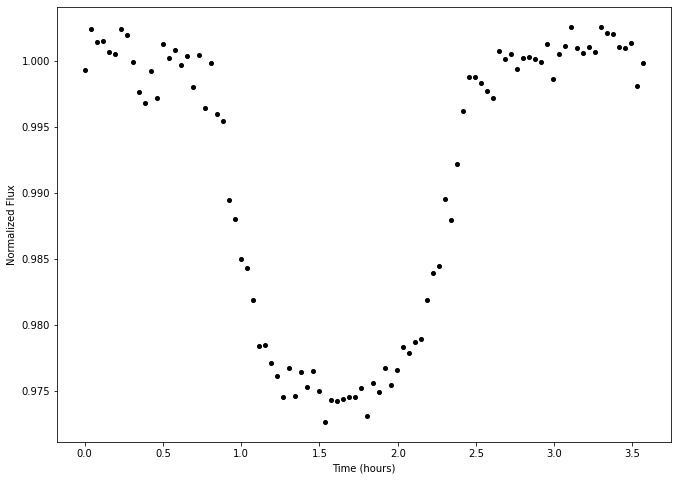

In [30]:
fig, ax = plt.subplots(figsize=(11,8))
ax.plot(transit["Time"], transit["Flux"], 'ok', markersize=4)

ax.set(
    xlabel=("Time (hours)"),
    ylabel=("Normalized Flux")
)

I will find the average flux during the transit compare to the average flux outside of it. This will allow us to use the equation to solve for the radius of the planet using the equation shown earlier.

In [8]:
noutside=[]                                     # Empty list we will put normalized fluxes of outside of the transit
ninside=[]                                     # Empty list we will put normalized fluxes of outside of the transit


for i in range(len(transit['HJD'])):            # Fill lists with normalized flux values
    if 0.9>transit['Time'][i]:
        noutside.append(transit['Flux'][i])
    elif 2.5<transit['Time'][i]:
        noutside.append(transit['Flux'][i])
    elif 1.25<transit['Time'][i]<2:
        ninside.append(transit['Flux'][i])

outflux=np.average(noutside)                   # Averaging
influx=np.average(ninside)

Finally we can solve for radius using the equation from the beginning
$$
f=(\frac{R_p}{R_*})^2
$$

knowing the radius of the star and now being able to find f.

In [9]:
f=outflux-influx                            # Transit depth
Rstar=0.78271930158600000                  # Host star radius in solar radii

Rcalc=f**0.5*9.73116*Rstar              # Finding planet radius. 9.73116 is the conversion from solar to jupiter radii.

print('The radius calculated was',round(Rcalc,3),'Jupiter radii.')

The radius calculated was 1.203 Jupiter radii.


So, we end up with a radius of
$$
1.203 R_J
$$

I feel that this is a decent result for finding a radius while making probably a ton of "ideal" assumptions and solving the problem in a simple way. It is a fairly close value to the 1.138 Jupiter radii found by Josep Gaitan, however not within its margin of error

# Finding Uncertainty of that Radius

Now that we have found the radius of the planet, we need to find the uncertainty. This will be done with Bayesian sampling and error propogation.

All error propogation done below follows the rules shown in the link in the background section at the top! And the steps are followed in the same order as done to find the radius.

First we converted from apparent magnitude to absolute magnitude, now we need to do the same thing but for the errors. The following equation is used again
$$
m-M=5log(d/10)
$$
where m is the apparent magnitude, M is the absolute magnitude, and d is the distance to the object in parsecs.

In [10]:
d=19.7109                            # Distance to system in pc
derr=0.0188                          # Error in distance in pc
abmagerr=[]                          # Empty list we will fill with absolute magnitude error values

for i in range(len(transit.Mag)):
    value=((5*derr/(np.log(10) * d))**2+transit['Err'][i]**2)**0.5          # Solve for Merr.
    abmagerr.append(value)                        # Append value onto list
transit['ErrAB']=abmagerr                        # Append to dataframe

transit.head()                                  # Check it worked

,HJD,Mag,Err,ABMag,Lum,Time,Flux,ErrAB
0,2.459435e+06,-0.00892,0.00156,-1.482452,334.950715,0.00000,0.999298,0.002593
1,2.459435e+06,-0.01234,0.00157,-1.485872,336.007452,0.03840,1.002451,0.002599
2,2.459435e+06,-0.01123,0.00155,-1.484762,335.664111,0.07704,1.001426,0.002587
3,2.459435e+06,-0.01129,0.00155,-1.484822,335.682661,0.11592,1.001482,0.002587
4,2.459435e+06,-0.01041,0.00155,-1.483942,335.410697,0.15432,1.000670,0.002587


Next we can convert these absolute magnitudes errors into luminosities errors using 
$$
M=4.83-2.5log(\frac{L}{L_0})
$$
again. We are going to assume that sun qualities (luminosity, radius, etc) have such small errors they can be neglected.

In [11]:
# Find luminosities in terms of L_0.

lumserr=[]                             # Empty list we will put calculated luminosities in

for i in range(len(transit.Mag)):
    value= (1/5)*transit['ErrAB'][i]*2*np.log(10)*10**(483/250-2*transit['Mag'][i]/5)
    lumserr.append(value)                        # Append value onto list

transit['ErrLum']=lumserr                           # Append 

transit.head()                                # Check it worked

,HJD,Mag,Err,ABMag,Lum,Time,Flux,ErrAB,ErrLum
0,2.459435e+06,-0.00892,0.00156,-1.482452,334.950715,0.00000,0.999298,0.002593,0.205888
1,2.459435e+06,-0.01234,0.00157,-1.485872,336.007452,0.03840,1.002451,0.002599,0.207017
2,2.459435e+06,-0.01123,0.00155,-1.484762,335.664111,0.07704,1.001426,0.002587,0.205848
3,2.459435e+06,-0.01129,0.00155,-1.484822,335.682661,0.11592,1.001482,0.002587,0.205860
4,2.459435e+06,-0.01041,0.00155,-1.483942,335.410697,0.15432,1.000670,0.002587,0.205693


Now to find flux errors...
$$
F=\frac{L}{4πd^2}
$$

In [12]:
# Find luminosities in terms of L_0.

fluxerr=[]                             # Empty list we will put calculated flux errors in

#Everything converted to SI
derrSI=derr*3.0856775814914*10**16
for i in range(len(transit.Mag)):
    
    numerator=lumsSI[i]*((3.828*10**26*transit['ErrLum'][i])**2+(2*dSI*derrSI)**2)**0.5
    
    denomenator= 8 * np.pi * dSI**3 * derrSI
    
    value= numerator/denomenator
    
    fluxerr.append(value)                        # Append value onto list
    
fluxerr=[i*10**5 for i in fluxerr]
    
transit['ErrFlux']=fluxerr
transit.head()                                 # Check it worked

,HJD,Mag,Err,ABMag,Lum,Time,Flux,ErrAB,ErrLum,ErrFlux
0,2.459435e+06,-0.00892,0.00156,-1.482452,334.950715,0.00000,0.999298,0.002593,0.205888,0.002758
1,2.459435e+06,-0.01234,0.00157,-1.485872,336.007452,0.03840,1.002451,0.002599,0.207017,0.002767
2,2.459435e+06,-0.01123,0.00155,-1.484762,335.664111,0.07704,1.001426,0.002587,0.205848,0.002764
3,2.459435e+06,-0.01129,0.00155,-1.484822,335.682661,0.11592,1.001482,0.002587,0.205860,0.002764
4,2.459435e+06,-0.01041,0.00155,-1.483942,335.410697,0.15432,1.000670,0.002587,0.205693,0.002762


Plot the same thing as before but with errorbars on the points now.

[Text(0, 0.5, 'Normalized Flux'), Text(0.5, 0, 'Time (hours)')]

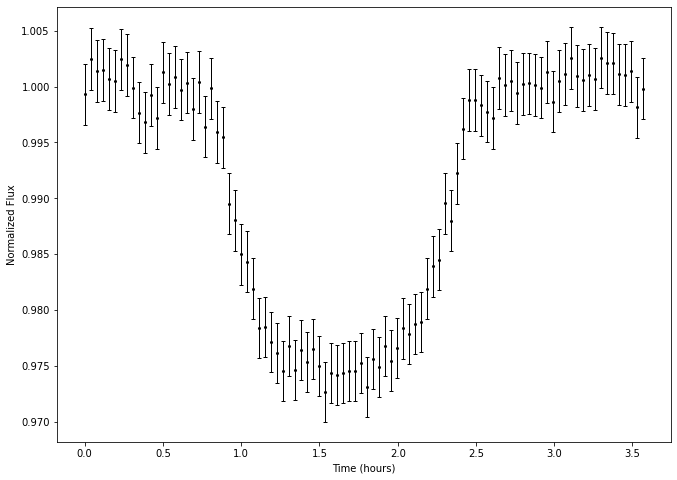

In [29]:
fig, ax = plt.subplots(figsize=(11,8))
#ax.scatter(transit["Time"], transit["Flux"],marker='.')
ax.errorbar(transit["Time"], transit["Flux"], yerr=transit['ErrFlux'], color='k', fmt='.', markersize=4, elinewidth=1, capsize=2)

ax.set(
    xlabel=("Time (hours)"),
    ylabel=("Normalized Flux")
)

Lastly we find the error in the radius with the equation



In [14]:
outerr=[]                                     # Empty list we will put normalized flux errors of outside of the transit
inerr=[]                                     # Empty list we will put normalized flux errors of inside of the transit


for i in range(len(transit['HJD'])):            # Fill lists with normalized flux error values
    if 0.9>transit['Time'][i]:
        outerr.append(transit['ErrFlux'][i])
    elif 2.5<transit['Time'][i]:
        outerr.append(transit['ErrFlux'][i])
    elif 1.25<transit['Time'][i]<2:
        inerr.append(transit['ErrFlux'][i])

outfluxerr=np.average(outerr)                   # Averaging
influxerr=np.average(inerr)

ferr=(outfluxerr**2-influxerr**2)**0.5*f**-0.5*0.5*9.73116
print('Our error in radius is',round(ferr,2),'Jupiter radii.')

Our error in radius is 0.02 Jupiter radii.


Finally, with all of that done, we end up with an error of
$$
0.02 R_J
$$

Making our result that the planet HD189733 b has a radius of 
$$
1.20 ± 0.02 R_J
$$